In [2]:
import numpy as np
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

from utils import solve_lp

## Packing

In [9]:
# Generate random parameters for the problem
m = 50  # Number of constraints
n = 500   # Number of variables
A = np.random.rand(m, n)     # Constraint matrix
b = np.random.rand(m) * n    # Right-hand side vector
w = np.random.rand(n)        # Coefficients of the objective function

N = 300 # Number of instances
As = np.tile(A, (N,1,1))
bs = np.tile(b, (N,1))
ws = np.tile(w, (N,1))

# Add noise
sigma = .1
As *= (1 + sigma * np.random.rand(*np.shape(As)))
bs *= (1 + sigma * np.random.rand(*np.shape(bs)))
ws *= (1 + sigma * np.random.rand(*np.shape(ws)))

# Solve (past) problems
xs = np.array([solve_lp(w=w, A=A, b=b)['x'] for w, A, b in zip(ws, As, bs)])

dir_name = 'packing'
file_name = f'm{m}_n{n}_sigma{sigma}'

# Save
np.savez(f'data/{dir_name}/{file_name}.npz', m=m, n=n, N=N, As=As, bs=bs, ws=ws, xs=xs, A_is_identical=False)

## Create a graph

found
6


/var/folders/dx/jqclx98137d089kylj7hq6_40000gn/T/ipykernel_79789/17381456.py:21: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Inc_mat = nx.incidence_matrix(G, oriented=True).todense()


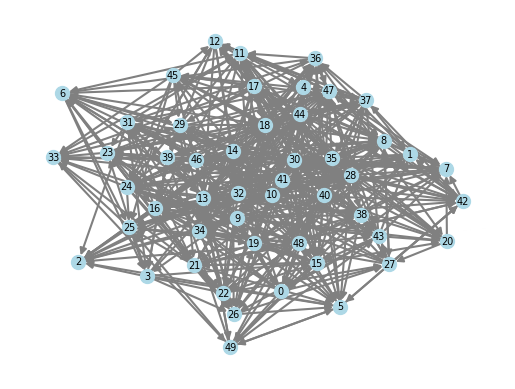

In [10]:
import networkx as nx
import matplotlib.pyplot as plt
import pickle

# Create a random graph G with (s, t)
n_nodes, n_edges = 50, 500
s, t = 0, n_nodes-1
for _ in range(100):
    G = nx.gnm_random_graph(n_nodes, n_edges, directed=True)
    if (s, t) in G.edges():
        print('found')
        break

# Add capacity and cost to each edge
for (u, v) in G.edges():
    G[u][v]['capacity'] = 1
    G[u][v]['cost'] = 1
G[s][t]['cost'] = np.sum([G[u][v]['cost'] for (u, v) in G.edges()])

# Get incidence matrix of the graph
Inc_mat = nx.incidence_matrix(G, oriented=True).todense()

# Test solving of the max-flow problem
print(nx.maximum_flow_value(G, s, t, capacity='capacity'))

# Visualize the graph
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, with_labels=False, node_color='lightblue', node_size=100, edge_color='gray', width=1.5)
nx.draw_networkx_labels(G, pos, labels={node: str(node) for node in G.nodes()}, font_size=7, font_color='black')
plt.axis('off')
plt.show()

## Maxflow

In [11]:
u = np.array([G[u][v]['capacity'] for (u, v) in G.edges()], dtype=np.float64)
w = -Inc_mat[0]

# Convert original LP (max w @ x st. Inc_mat[1:-1] @ x = 0, 0 <= x <= u) into inequality LP form (max w @ N_eq @ x st. 0 <= N_eq @ x <= u)
N_eq = np.eye(len(w)) - np.linalg.lstsq(Inc_mat[1:-1], Inc_mat[1:-1])[0]
w = N_eq.T @ w
A = np.r_[N_eq, -N_eq]

# Make random instances
N = 300
sigma = .1

As = np.tile(A, (N,1,1))
ws = np.tile(w, (N,1))
us = np.tile(u, (N,1))
us *= (1 + sigma * np.random.rand(*np.shape(us)))
bs = np.array([np.r_[u, np.zeros(n_edges)] for u in us])

xs = np.array([solve_lp(w=w, A=A, b=b)['x'] for w, A, b in zip(ws, As, bs)])

m, n = A.shape
dir_name = 'maxflow'
file_name = f'm{m}_n{n}_sigma{sigma}'

# Save
np.savez(f'data/{dir_name}/{file_name}.npz', m=m, n=n, N=N, As=As, bs=bs, ws=ws, xs=xs, A_is_identical=True)
with open(f'data/{dir_name}/{file_name}_graph.pkl', 'wb') as f:
     pickle.dump(G, f)

/var/folders/dx/jqclx98137d089kylj7hq6_40000gn/T/ipykernel_79789/2824435986.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  N_eq = np.eye(len(w)) - np.linalg.lstsq(Inc_mat[1:-1], Inc_mat[1:-1])[0]


## Min-cost flow

In [12]:
u = np.array([G[u][v]['capacity'] for (u, v) in G.edges()], dtype=np.float64)
c = np.array([G[u][v]['cost'] for (u, v) in G.edges()], dtype=np.float64)
demand = 1
d = np.zeros(len(Inc_mat))
d[t] = demand
d[s] = -demand

# Get a trivial feasible solution that costs cost_sum
st_id = np.where(np.logical_and(Inc_mat[s] < 0, Inc_mat[t] > 0))[0]
x0 = np.zeros(len(c))
x0[st_id] = demand

# x = N_eq @ x + x0, where x = 0 is feasible
N_eq = np.eye(len(c)) -  np.linalg.lstsq(Inc_mat, Inc_mat)[0]
A = np.r_[N_eq, -N_eq]

N = 300
sigma = .1

As = np.tile(A, (N,1,1))
cs = np.tile(c, (N,1))
cs *= (1 + sigma * np.random.rand(*np.shape(cs)))
ws = np.array([-N_eq @ c for c in cs])

us = np.tile(u, (N,1))
us *= (1 + sigma * np.random.rand(*np.shape(us)))
bs = np.array([np.r_[u - x0, x0] for u in us])

xs = np.array([solve_lp(w=w, A=A, b=b)['x'] for w, A, b in zip(ws, As, bs)])

m, n = A.shape
dir_name = 'mincostflow'
file_name = f'm{m}_n{n}_sigma{sigma}'

# Save
np.savez(f'data/{dir_name}/{file_name}.npz', m=m, n=n, N=N, As=As, bs=bs, ws=ws, xs=xs, A_is_identical=True)
with open(f'data/{dir_name}/{file_name}_graph.pkl', 'wb') as f:
    pickle.dump(G, f)

/var/folders/dx/jqclx98137d089kylj7hq6_40000gn/T/ipykernel_79789/2639192089.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  N_eq = np.eye(len(c)) -  np.linalg.lstsq(Inc_mat, Inc_mat)[0]
